# Feature Set Comparison

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

## Read in and Split Data

In [3]:
# read in data
data = pd.read_csv('../data/unemployment_data.csv')
data.head()

initclaims_rate_regular  FIPS    State   County  Deaths  \
0                  26.0512  1001  Alabama  Autauga     791   
1                  30.8648  1003  Alabama  Baldwin    2967   
2                  24.5891  1005  Alabama  Barbour     472   
3                  35.7501  1007  Alabama     Bibb     471   
4                  15.1614  1009  Alabama   Blount    1085   

   Years of Potential Life Lost Rate  % Fair or Poor Health  \
0                         8128.59119              20.882987   
1                         7354.12253              17.509134   
2                        10253.57340              29.591802   
3                        11977.53948              19.439724   
4                        11335.07113              21.745293   

   Average Number of Physically Unhealthy Days  \
0                                     4.743889   
1                                     4.224519   
2                                     5.430279   
3                                     4.591482   
4                                     4.860808   

   Average Number of Mentally Unhealthy Days  % Low Birthweight  ...  \
0                                   4.654031           8.619529  ...   
1                                   4.304056           8.345003  ...   
2                                   5.185594          11.474559  ...   
3                                   4.551699          10.308710  ...   
4                                   4.891455           7.604563  ...   

   % Below Poverty  Median Household Income  % No College Degree  \
0             12.1                    58233            16.107796   
1             10.1                    59871            21.044656   
2             27.1                    35972             7.609664   
3             20.3                    47918             6.451014   
4             16.3                    52902             8.625066   

   Unemployment Rate  % Not in Labor Force  % Jobs in Leisure and Hospitality  \
0                2.7             40.454576                          14.216260   
1                2.7             43.511495                          20.823355   
2                3.8             58.630549                           9.248695   
3                3.1             53.033744                           4.345937   
4                2.7             44.821051                          10.342057   

   % Part-time  % Self-Employed  Presence of Water Violation (dummy Y/N)  \
0    39.604710         7.283256                                        0   
1    40.364194        12.669969                                        0   
2    54.696722         9.675502                                        0   
3    52.112959         7.547395                                        0   
4    47.550659         7.815851                                        0   

   Other Primary Care Provider Ratio (:1)  
0                                    2527  
1                                    1787  
2                                    1914  
3                                     896  
4                                    4449  

[5 rows x 102 columns]

In [4]:
data["Hospitals per 100,000"] = round((data["Number of Hospitals"]/data.Population) * 100000, 1)

In [5]:
X = data.drop(["FIPS", "initclaims_rate_regular", "Hospitals per 100,000", "State", "County", "Number of Hospitals"], axis=1)
y = pd.DataFrame(data["Hospitals per 100,000"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
len(X.columns)

97

## Dummy Baseline

In [9]:
y_train_mean = y_train.mean()
y_train_mean

Hospitals per 100,000    4.990989
dtype: float64

In [10]:
(((y_test - y_train_mean)**2).sum())**(.5)

Hospitals per 100,000    106.897524
dtype: float64

## Proxy Histogram

<AxesSubplot:>

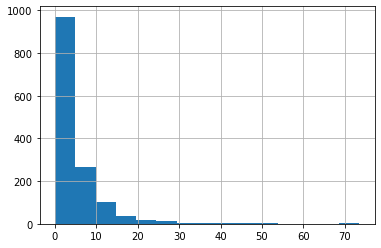

In [17]:
data["Hospitals per 100,000"].hist(bins=15)

## MLP: XGBoost Most Important Features

In [127]:
X_train_x = X_train.filter(['Primary Care Physicians Rate', '% Long Commute - Drives Alone',
                'Social Association Rate', 'Deaths', '% Vaccinated', 
                '% With Access to Exercise Opportunities', 'Other Primary Care Provider Ratio (:1)'])

X_val_x = X_val.filter(['Primary Care Physicians Rate', '% Long Commute - Drives Alone',
                'Social Association Rate', 'Deaths', '% Vaccinated', 
                '% With Access to Exercise Opportunities', 'Other Primary Care Provider Ratio (:1)'])

X_test_x = X_test.filter(['Primary Care Physicians Rate', '% Long Commute - Drives Alone',
                'Social Association Rate', 'Deaths', '% Vaccinated', 
                '% With Access to Exercise Opportunities', 'Other Primary Care Provider Ratio (:1)'])

In [128]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [129]:
train_data_x = PrepareData(X_train_x, y_train)
val_data_x = PrepareData(X_val_x, y_val)
test_data_x = PrepareData(X_test_x, y_test)

In [130]:
batch_size = 8

In [131]:
train_loader_x = DataLoader(train_data_x, 
                          batch_size)

valid_loader_x = DataLoader(val_data_x, 
                          batch_size)

test_loader_x = DataLoader(test_data_x, 
                         batch_size)

In [132]:
class MLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [137]:
mlp = MLP(input_dim=7)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [138]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(50):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_x.model')

Epoch: 1 	Training Loss: 8.567242 	Validation Loss: 5.078517
Epoch: 2 	Training Loss: 7.166490 	Validation Loss: 5.086089
Epoch: 3 	Training Loss: 6.919647 	Validation Loss: 5.051398
Epoch: 4 	Training Loss: 6.724993 	Validation Loss: 4.964378
Epoch: 5 	Training Loss: 6.696238 	Validation Loss: 4.936093
Epoch: 6 	Training Loss: 6.667590 	Validation Loss: 4.867566
Epoch: 7 	Training Loss: 6.531870 	Validation Loss: 4.791171
Epoch: 8 	Training Loss: 6.456737 	Validation Loss: 4.710539
Epoch: 9 	Training Loss: 6.419103 	Validation Loss: 4.640957
Epoch: 10 	Training Loss: 6.273300 	Validation Loss: 4.581375
Epoch: 11 	Training Loss: 6.323785 	Validation Loss: 4.514488
Epoch: 12 	Training Loss: 6.172856 	Validation Loss: 4.423716
Epoch: 13 	Training Loss: 6.050397 	Validation Loss: 4.318099
Epoch: 14 	Training Loss: 5.927238 	Validation Loss: 4.178544
Epoch: 15 	Training Loss: 5.747817 	Validation Loss: 3.957649
Epoch: 16 	Training Loss: 5.664615 	Validation Loss: 3.901376
Epoch: 17 	Traini

In [139]:
best_val_loss

3.43893406719997

In [140]:
mlp.load_state_dict(torch.load('mlp_x.model'))

In [141]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_x)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 4.286951



### Explain output through SHAP

In [142]:
mlp = MLP(input_dim=7)
mlp.load_state_dict(torch.load('mlp_x.model'))

In [143]:
x_x, _ = next(iter(train_loader_x))

In [144]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x)

shap_values = explainer_shap.shap_values(X=x_x,
                                      ranked_outputs=True)

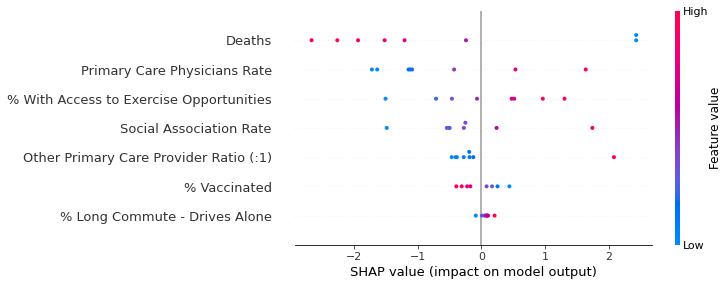

In [145]:
shap.summary_plot(shap_values, x_x, feature_names=X_train_x.columns)

## MLP: Original Features

In [146]:
X_train_o = X_train.filter(['% Rural', '% households wo car', 
                            '% workers commuting by public transit', 
                            'Primary Care Physicians Rate', '% Without Health Insurance',
                            '% Nonwhite', '% Limited English Proficiency', 
                            '% Veterans in Civilian Adult Population', '% Adults 65 and Older',
                            '% disabled', 'opioid death rate', '% Fair or Poor Health'])

X_val_o = X_val.filter(['% Rural', '% households wo car', 
                            '% workers commuting by public transit', 
                            'Primary Care Physicians Rate', '% Without Health Insurance',
                            '% Nonwhite', '% Limited English Proficiency', 
                            '% Veterans in Civilian Adult Population', '% Adults 65 and Older',
                            '% disabled', 'opioid death rate', '% Fair or Poor Health'])

X_test_o = X_test.filter(['% Rural', '% households wo car', 
                            '% workers commuting by public transit', 
                            'Primary Care Physicians Rate', '% Without Health Insurance',
                            '% Nonwhite', '% Limited English Proficiency', 
                            '% Veterans in Civilian Adult Population', '% Adults 65 and Older',
                            '% disabled', 'opioid death rate', '% Fair or Poor Health'])

In [147]:
train_data_o = PrepareData(X_train_o, y_train)
val_data_o = PrepareData(X_val_o, y_val)
test_data_o = PrepareData(X_test_o, y_test)

In [148]:
train_loader_o = DataLoader(train_data_o, 
                          batch_size)

valid_loader_o = DataLoader(val_data_o, 
                          batch_size)

test_loader_o = DataLoader(test_data_o, 
                         batch_size)

In [156]:
mlp = MLP(input_dim = 12)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [157]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(50):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_o.model')

Epoch: 1 	Training Loss: 6.332373 	Validation Loss: 4.188337
Epoch: 2 	Training Loss: 5.930470 	Validation Loss: 4.080469
Epoch: 3 	Training Loss: 5.754762 	Validation Loss: 4.032285
Epoch: 4 	Training Loss: 5.731904 	Validation Loss: 4.031472
Epoch: 5 	Training Loss: 5.644931 	Validation Loss: 4.008370
Epoch: 6 	Training Loss: 5.715170 	Validation Loss: 4.012742
Epoch: 7 	Training Loss: 5.772239 	Validation Loss: 4.014428
Epoch: 8 	Training Loss: 5.726967 	Validation Loss: 4.003557
Epoch: 9 	Training Loss: 5.755328 	Validation Loss: 4.045912
Epoch: 10 	Training Loss: 5.622001 	Validation Loss: 3.982414
Epoch: 11 	Training Loss: 5.634415 	Validation Loss: 3.958259
Epoch: 12 	Training Loss: 5.650463 	Validation Loss: 3.971206
Epoch: 13 	Training Loss: 5.623897 	Validation Loss: 3.956808
Epoch: 14 	Training Loss: 5.612549 	Validation Loss: 3.985122
Epoch: 15 	Training Loss: 5.616266 	Validation Loss: 3.939787
Epoch: 16 	Training Loss: 5.608469 	Validation Loss: 3.952218
Epoch: 17 	Traini

In [158]:
best_val_loss

3.7862290431713235

In [159]:
mlp.load_state_dict(torch.load('mlp_o.model'))

In [160]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 4.971338



### Explain output through SHAP

In [162]:
mlp = MLP(input_dim = 12)
mlp.load_state_dict(torch.load('mlp_o.model'))

In [163]:
x_o, _ = next(iter(train_loader_o))

In [164]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o)

shap_values = explainer_shap.shap_values(X=x_o,
                                      ranked_outputs=True)

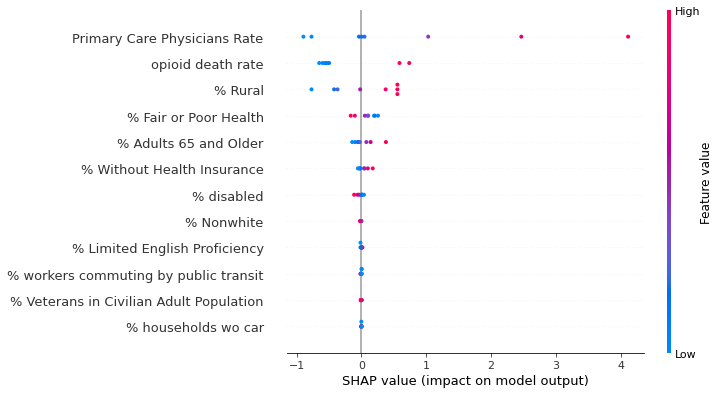

In [165]:
shap.summary_plot(shap_values, x_o, feature_names=X_train_o.columns)